In [11]:
import torch
import torchvision
import torchvision.transforms as T
import pandas as pd
from PIL import Image
import os
import logging
from torch.utils.data import Dataset

print("PyTorch version:", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


PyTorch version: 2.5.1+cu118
Device: cuda


In [5]:
acuity_path = "../Choithram Netralaya Data/acuityvalues.xlsx"

df = pd.read_excel(acuity_path)

display(df.head())

print("Columns in the dataset:")
print(df.columns)

First few rows of the acuity values dataframe:


,patient,r sphere,r cylinder,l sphere,l cylinder
0,1,0.25,-0.25,0.00,-0.25
1,2,-0.50,-0.50,0.00,-0.50
2,3,1.75,-0.75,0.00,-0.25
3,4,0.25,0.00,0.25,0.00
4,5,0.25,0.25,0.25,0.00


Columns in the dataset:
Index(['patient', 'r sphere', 'r cylinder', 'l sphere', 'l cylinder'], dtype='object')


In [9]:
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

filtered_df = df.copy()
numeric_cols = ['r sphere', 'r cylinder', 'l sphere', 'l cylinder']

filtered_df = filtered_df.dropna(subset=numeric_cols)

df_patients = set(map(str, filtered_df['patient'].unique()))

data_dir = "../Choithram Netralaya Data/Images"
image_patients = set()
if os.path.exists(data_dir):
    for folder_name in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder_name)
        if os.path.isdir(folder_path):
            image_patients.add(folder_name)
else:
    logging.warning("Image directory does not exist!")

all_patients = df_patients.union(image_patients)

valid_patients = []
logging.info(f"Total patients in DF (after NaN drop): {len(df_patients)}")
logging.info(f"Total patients in image directory: {len(image_patients)}")
logging.info(f"Combined unique patients: {len(all_patients)}")

for patient_id in sorted(all_patients, key=lambda x: int(x)):
    if patient_id not in df_patients:
        logging.info(f"Skipping patient {patient_id}: no numeric values found in DataFrame.")
        continue
    row = filtered_df.loc[filtered_df['patient'] == int(patient_id)].head(1)
    if row.empty:
        logging.info(f"Skipping patient {patient_id}: filtered out due to missing numeric data.")
        continue

    left_ir_path = os.path.join(data_dir, patient_id, f"{patient_id}_LEFT_IR.jpg")
    right_ir_path = os.path.join(data_dir, patient_id, f"{patient_id}_RIGHT_IR.jpg")

    left_exists = os.path.exists(left_ir_path)
    right_exists = os.path.exists(right_ir_path)

    if not left_exists and not right_exists:
        logging.info(f"Skipping patient {patient_id}: LEFT_IR and RIGHT_IR images missing.")
        continue
    elif not left_exists:
        logging.info(f"Skipping patient {patient_id}: LEFT_IR image missing.")
        continue
    elif not right_exists:
        logging.info(f"Skipping patient {patient_id}: RIGHT_IR image missing.")
        continue

    logging.info(f"Including patient {patient_id}: Numeric and IR images available.")
    valid_patients.append(patient_id)

valid_patient_ids = set(map(int, valid_patients))
filtered_df = filtered_df[filtered_df['patient'].isin(valid_patient_ids)].reset_index(drop=True)

logging.info(f"Number of valid patients after filtering: {len(filtered_df)}")


INFO: Total patients in DF (after NaN drop): 302
INFO: Total patients in image directory: 343
INFO: Combined unique patients: 343
INFO: Skipping patient 1: LEFT_IR image missing.
INFO: Including patient 2: Numeric and IR images available.
INFO: Including patient 3: Numeric and IR images available.
INFO: Including patient 4: Numeric and IR images available.
INFO: Including patient 5: Numeric and IR images available.
INFO: Including patient 6: Numeric and IR images available.
INFO: Including patient 7: Numeric and IR images available.
INFO: Including patient 8: Numeric and IR images available.
INFO: Including patient 9: Numeric and IR images available.
INFO: Including patient 10: Numeric and IR images available.
INFO: Including patient 11: Numeric and IR images available.
INFO: Including patient 12: Numeric and IR images available.
INFO: Including patient 13: Numeric and IR images available.
INFO: Including patient 14: Numeric and IR images available.
INFO: Including patient 15: Numeric 

In [10]:
filtered_df.head()

,patient,r sphere,r cylinder,l sphere,l cylinder
0,2,-0.50,-0.50,0.00,-0.50
1,3,1.75,-0.75,0.00,-0.25
2,4,0.25,0.00,0.25,0.00
3,5,0.25,0.25,0.25,0.00
4,6,-1.50,-1.25,-0.75,-1.25


In [17]:
class EyeIRDataset(Dataset):
    def __init__(self, df, data_dir, transform=None):
        self.df = df
        self.data_dir = data_dir
        self.transform = transform
        self.numeric_cols = ['r sphere', 'r cylinder', 'l sphere', 'l cylinder']

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        patient_id = str(int(row['patient']))

        numeric_features = torch.tensor([row[col] for col in self.numeric_cols], dtype=torch.float)

        target = numeric_features.clone()

        left_ir_path = os.path.join(self.data_dir, patient_id, f"{patient_id}_LEFT_IR.jpg")
        right_ir_path = os.path.join(self.data_dir, patient_id, f"{patient_id}_RIGHT_IR.jpg")

        left_img = Image.open(left_ir_path).convert("RGB")
        right_img = Image.open(right_ir_path).convert("RGB")

        if self.transform:
            left_img = self.transform(left_img)
            right_img = self.transform(right_img)

        return {
            "patient_id": patient_id,
            "left_ir": left_img,
            "right_ir": right_img,
            "numeric_features": numeric_features,
            "target": target
        }


In [18]:
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])

data_dir = "../Choithram Netralaya Data/Images"
dataset = EyeIRDataset(filtered_df, data_dir, transform=transform)


In [19]:
sample = dataset[0]

print("Keys in sample:", sample.keys())
print("Patient ID:", sample['patient_id'])
print("Left IR image shape:", sample['left_ir'].shape)
print("Right IR image shape:", sample['right_ir'].shape)
print("Numeric features:", sample['numeric_features'])
print("Target:", sample['target'])


Keys in sample: dict_keys(['patient_id', 'left_ir', 'right_ir', 'numeric_features', 'target'])
Patient ID: 2
Left IR image shape: torch.Size([3, 224, 224])
Right IR image shape: torch.Size([3, 224, 224])
Numeric features: tensor([-0.5000, -0.5000,  0.0000, -0.5000])
Target: tensor([-0.5000, -0.5000,  0.0000, -0.5000])


## Model --- ResNet18 ---

In [20]:
import torch
import torch.nn as nn
import torchvision.models as models

class NumericMLP(nn.Module):
    def __init__(self, input_dim=4, hidden_dims=[64, 32]):
        super(NumericMLP, self).__init__()
        layers = []
        in_dim = input_dim
        for hd in hidden_dims:
            layers.append(nn.Linear(in_dim, hd))
            layers.append(nn.ReLU())
            in_dim = hd
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        return self.mlp(x)

class EyeModel(nn.Module):
    def __init__(self, output_dim=4):
        super(EyeModel, self).__init__()
        # Pretrained CNN
        self.cnn = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.cnn.fc = nn.Identity()

        # Numeric branch
        self.numeric_branch = NumericMLP(input_dim=4, hidden_dims=[64,32])

        # Compress left/right features (1024) -> 512
        self.img_compress = nn.Linear(1024, 512)

        # Final FC layers after concatenation of image features (512) and numeric (32)
        self.fc = nn.Sequential(
            nn.Linear(512 + 32, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, left_ir, right_ir, numeric):
        left_feat = self.cnn(left_ir)   # [batch, 512]
        right_feat = self.cnn(right_ir) # [batch, 512]

        # Combine image features
        combined_img_feat = torch.cat([left_feat, right_feat], dim=1) # [batch, 1024]

        # Compress to 512
        combined_img_feat = self.img_compress(combined_img_feat) # [batch, 512]

        # Numeric features
        numeric_feat = self.numeric_branch(numeric) # [batch, 32]

        # Concatenate image and numeric
        fused = torch.cat([combined_img_feat, numeric_feat], dim=1) # [batch, 544]

        # Predict
        out = self.fc(fused) # [batch, 4]
        return out

In [21]:
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
batch = next(iter(dataloader))

# Move the batch to device if using GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EyeModel(output_dim=4).to(device)

left_ir = batch['left_ir'].to(device)        # [8, 3, 224, 224]
right_ir = batch['right_ir'].to(device)      # [8, 3, 224, 224]
numeric = batch['numeric_features'].to(device) # [8, 4]

with torch.no_grad():
    output = model(left_ir, right_ir, numeric)

print("Model output shape:", output.shape)  # Should be [8, 4]

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\sksse/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:11<00:00, 4.03MB/s]


Model output shape: torch.Size([8, 4])


In [22]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

### Example

In [23]:
epochs = 2
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_data in dataloader:
        left_ir = batch_data['left_ir'].to(device)
        right_ir = batch_data['right_ir'].to(device)
        numeric = batch_data['numeric_features'].to(device)
        target = batch_data['target'].to(device)

        optimizer.zero_grad()
        pred = model(left_ir, right_ir, numeric)
        loss = criterion(pred, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * left_ir.size(0)
    avg_loss = total_loss / len(dataset)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

Epoch [1/2], Loss: 12.5426
Epoch [2/2], Loss: 7.4189


## spliting 80 - 20

In [26]:
from sklearn.model_selection import train_test_split

indices = list(range(len(filtered_df)))
train_idx, test_idx = train_test_split(indices, test_size=0.20, random_state=42)

print("Number of training samples:", len(train_idx))
print("Number of testing samples:", len(test_idx))

Number of training samples: 236
Number of testing samples: 59


## Creating Subset Data for train and test

In [28]:
from torch.utils.data import Subset

train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)

print("Train dataset size:", len(train_dataset))
print("Test dataset size:", len(test_dataset))

Train dataset size: 236
Test dataset size: 59


In [29]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [30]:
model = EyeModel(output_dim=4).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

epochs = 30
for epoch in range(epochs):
    model.train()
    total_loss = 0
    count = 0
    for batch_data in train_loader:
        left_ir = batch_data['left_ir'].to(device)
        right_ir = batch_data['right_ir'].to(device)
        numeric = batch_data['numeric_features'].to(device)
        target = batch_data['target'].to(device)

        optimizer.zero_grad()
        pred = model(left_ir, right_ir, numeric)
        loss = criterion(pred, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * left_ir.size(0)
        count += left_ir.size(0)

    avg_train_loss = total_loss / count
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}")


Epoch [1/5], Train Loss: 13.3664
Epoch [2/5], Train Loss: 9.4258
Epoch [3/5], Train Loss: 5.6721
Epoch [4/5], Train Loss: 5.5000
Epoch [5/5], Train Loss: 5.8728


##  Evaluting The scores

In [31]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    count = 0
    with torch.no_grad():
        for batch_data in dataloader:
            left_ir = batch_data['left_ir'].to(device)
            right_ir = batch_data['right_ir'].to(device)
            numeric = batch_data['numeric_features'].to(device)
            target = batch_data['target'].to(device)

            pred = model(left_ir, right_ir, numeric)
            loss = criterion(pred, target)

            total_loss += loss.item() * left_ir.size(0)
            count += left_ir.size(0)
    avg_loss = total_loss / count if count > 0 else 0
    return avg_loss

test_loss = evaluate(model, test_loader, criterion, device)
print("Final Test Loss:", test_loss)


Final Test Loss: 6.874849190146236


In [34]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.01):
        """
        Args:
            patience (int): How many epochs to wait after last improvement before stopping.
            delta (float): Minimum change to qualify as an improvement.
        """
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Instantiate EarlyStopping
early_stopping = EarlyStopping(patience=5, delta=0.01)

epochs = 30
for epoch in range(epochs):
    # Training loop
    model.train()
    total_train_loss = 0
    train_count = 0
    for batch_data in train_loader:
        left_ir = batch_data['left_ir'].to(device)
        right_ir = batch_data['right_ir'].to(device)
        numeric = batch_data['numeric_features'].to(device)
        target = batch_data['target'].to(device)

        optimizer.zero_grad()
        pred = model(left_ir, right_ir, numeric)
        loss = criterion(pred, target)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * left_ir.size(0)
        train_count += left_ir.size(0)

    avg_train_loss = total_train_loss / train_count

    # Validation loop (directly included)
    model.eval()
    total_val_loss = 0
    val_count = 0
    with torch.no_grad():
        for batch_data in test_loader:
            left_ir = batch_data['left_ir'].to(device)
            right_ir = batch_data['right_ir'].to(device)
            numeric = batch_data['numeric_features'].to(device)
            target = batch_data['target'].to(device)

            pred = model(left_ir, right_ir, numeric)
            loss = criterion(pred, target)

            total_val_loss += loss.item() * left_ir.size(0)
            val_count += left_ir.size(0)

    avg_val_loss = total_val_loss / val_count if val_count > 0 else 0

    # Print training and validation loss
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Early stopping check
    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break


Epoch [1/30], Train Loss: 3.1585, Val Loss: 7.6795
Epoch [2/30], Train Loss: 3.0584, Val Loss: 8.1149
Epoch [3/30], Train Loss: 3.1391, Val Loss: 6.5108
Epoch [4/30], Train Loss: 3.1822, Val Loss: 6.7520
Epoch [5/30], Train Loss: 2.3123, Val Loss: 6.8524
Epoch [6/30], Train Loss: 2.9186, Val Loss: 6.2960
Epoch [7/30], Train Loss: 2.1147, Val Loss: 5.7747
Epoch [8/30], Train Loss: 1.9036, Val Loss: 6.7948
Epoch [9/30], Train Loss: 1.9375, Val Loss: 7.3137
Epoch [10/30], Train Loss: 2.5423, Val Loss: 6.4578
Epoch [11/30], Train Loss: 2.2181, Val Loss: 5.5053
Epoch [12/30], Train Loss: 1.8890, Val Loss: 4.8419
Epoch [13/30], Train Loss: 1.2294, Val Loss: 5.3710
Epoch [14/30], Train Loss: 1.2313, Val Loss: 4.7999
Epoch [15/30], Train Loss: 1.1944, Val Loss: 5.7457
Epoch [16/30], Train Loss: 0.9668, Val Loss: 4.6029
Epoch [17/30], Train Loss: 1.0070, Val Loss: 4.5684
Epoch [18/30], Train Loss: 1.3060, Val Loss: 4.6827
Epoch [19/30], Train Loss: 0.9115, Val Loss: 4.9786
Epoch [20/30], Train 

In [35]:
# Test evaluation
model.eval()
total_test_loss = 0
test_count = 0
with torch.no_grad():
    for batch_data in test_loader:
        left_ir = batch_data['left_ir'].to(device)
        right_ir = batch_data['right_ir'].to(device)
        numeric = batch_data['numeric_features'].to(device)
        target = batch_data['target'].to(device)

        pred = model(left_ir, right_ir, numeric)
        loss = criterion(pred, target)

        total_test_loss += loss.item() * left_ir.size(0)
        test_count += left_ir.size(0)

avg_test_loss = total_test_loss / test_count
print("Final Test Loss:", avg_test_loss)

Final Test Loss: 2.918476589655472


INFO: generated new fontManager


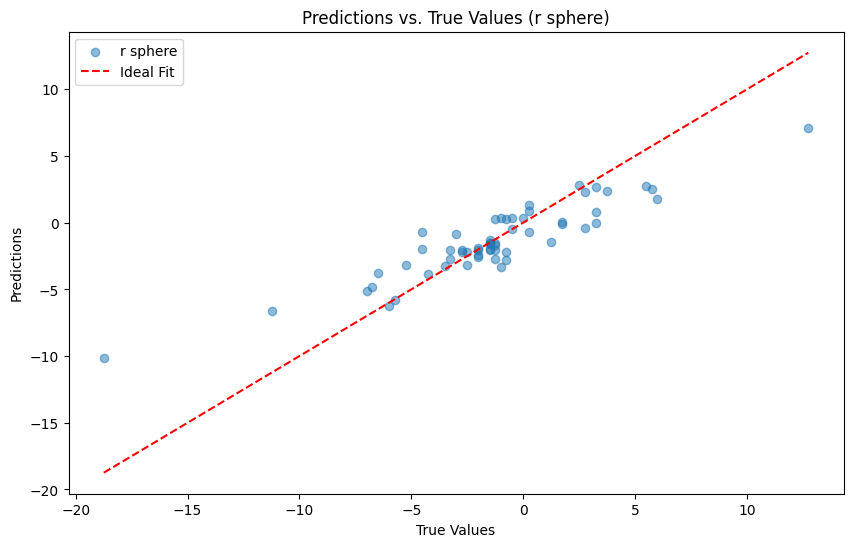

In [36]:
# Visualize predictions vs. targets
import matplotlib.pyplot as plt

predictions = []
targets = []

with torch.no_grad():
    for batch_data in test_loader:
        left_ir = batch_data['left_ir'].to(device)
        right_ir = batch_data['right_ir'].to(device)
        numeric = batch_data['numeric_features'].to(device)
        target = batch_data['target'].to(device)

        pred = model(left_ir, right_ir, numeric)
        predictions.append(pred.cpu())
        targets.append(target.cpu())

predictions = torch.cat(predictions).numpy()
targets = torch.cat(targets).numpy()

# Plot predictions vs. actual targets for one numeric value
plt.figure(figsize=(10, 6))
plt.scatter(targets[:, 0], predictions[:, 0], alpha=0.5, label="r sphere")
plt.plot([min(targets[:, 0]), max(targets[:, 0])], [min(targets[:, 0]), max(targets[:, 0])], 'r--', label="Ideal Fit")
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("Predictions vs. True Values (r sphere)")
plt.legend()
plt.show()

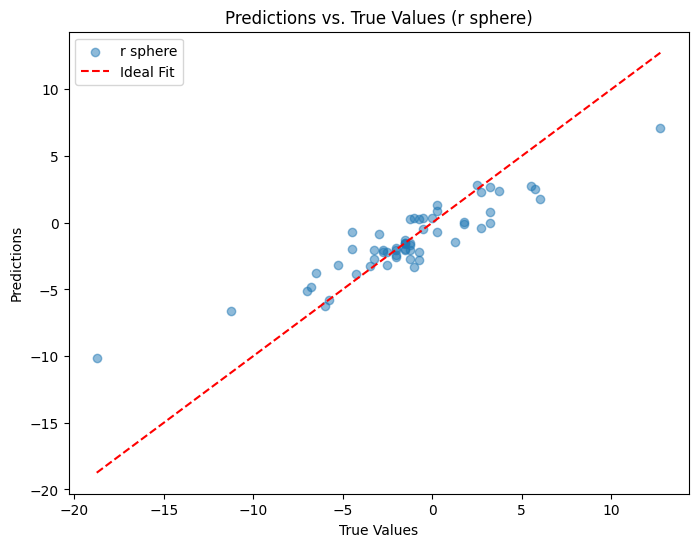

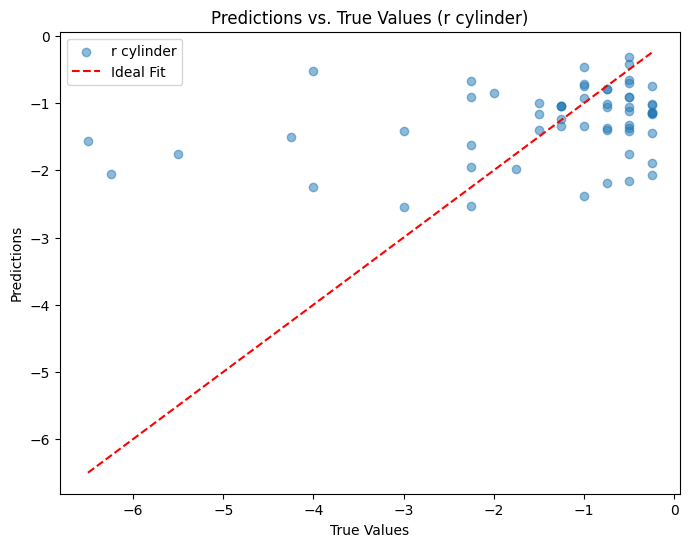

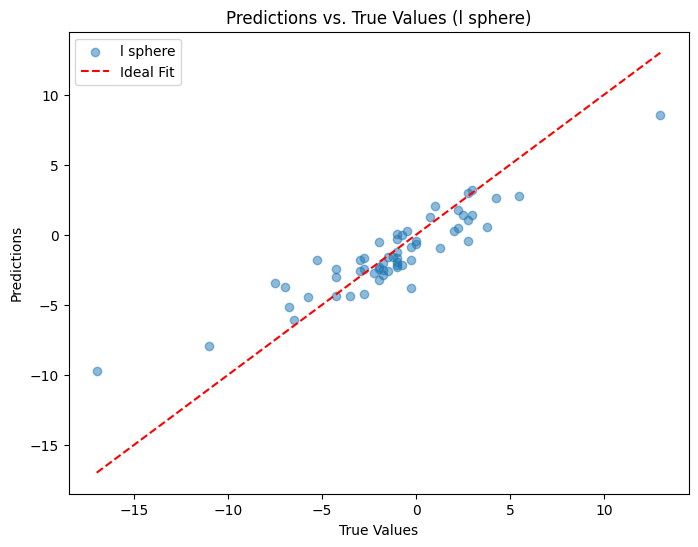

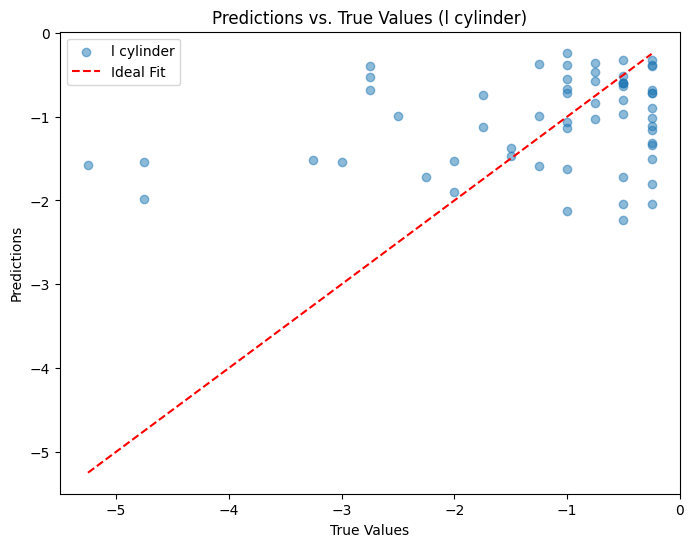

In [37]:
import matplotlib.pyplot as plt

predictions = []
targets = []

model.eval()
with torch.no_grad():
    for batch_data in test_loader:
        left_ir = batch_data['left_ir'].to(device)
        right_ir = batch_data['right_ir'].to(device)
        numeric = batch_data['numeric_features'].to(device)
        target = batch_data['target'].to(device)

        pred = model(left_ir, right_ir, numeric)
        predictions.append(pred.cpu())
        targets.append(target.cpu())

predictions = torch.cat(predictions).numpy()
targets = torch.cat(targets).numpy()

# Plot predictions vs. actual targets for each numeric feature
feature_names = ['r sphere', 'r cylinder', 'l sphere', 'l cylinder']
for i in range(4):
    plt.figure(figsize=(8, 6))
    plt.scatter(targets[:, i], predictions[:, i], alpha=0.5, label=feature_names[i])
    plt.plot([min(targets[:, i]), max(targets[:, i])], [min(targets[:, i]), max(targets[:, i])], 'r--', label="Ideal Fit")
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    plt.title(f"Predictions vs. True Values ({feature_names[i]})")
    plt.legend()
    plt.show()


Correlation Matrix:
            r sphere  r cylinder  l sphere  l cylinder
r sphere    1.000000    0.195200  0.906048    0.176986
r cylinder  0.195200    1.000000  0.194052    0.749003
l sphere    0.906048    0.194052  1.000000    0.204529
l cylinder  0.176986    0.749003  0.204529    1.000000


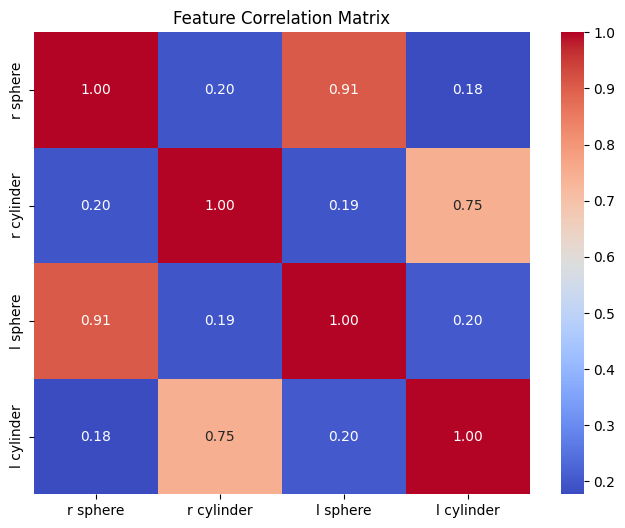

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

numerical_features = filtered_df[['r sphere', 'r cylinder', 'l sphere', 'l cylinder']]

correlation_matrix = numerical_features.corr()

# Display correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Plot a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()